In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
train = pd.read_pickle("./data/train.pkl")
test = pd.read_pickle("./data/test.pkl")


train_DL = pd.read_pickle("./data/train_DL.pkl")
test_DL = pd.read_pickle("./data/test_DL.pkl")
val_DL = pd.read_pickle("./data/validate_DL.pkl")

In [45]:
def load_data(train, test):
    train_X = np.array(train.loc[:,~train.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    train_Y = np.array(train.pIC50)
    test_X = np.array(test.loc[:,~test.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    test_Y = np.array(test.pIC50)

    return train_X, train_Y, test_X, test_Y

def load_data_DL(train_DL, test_DL, val_DL):
    train_X = np.array(train_DL.loc[:,~train_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    train_Y = np.array(train_DL.pIC50)
    test_X = np.array(test_DL.loc[:,~test_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    test_Y = np.array(test_DL.pIC50)
    val_X = np.array(val_DL.loc[:,~val_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    val_Y = np.array(val_DL.pIC50)

    return train_X, train_Y, test_X, test_Y, val_X, val_Y

def root_mean_squared_error(test_y, pred_y):
    return np.sqrt(mean_squared_error(test_y, pred_y))

def evaluate(train_Y, pred_Y_train, test_Y, pred_Y_test):
    print("Train Root Mean Squared Error:", root_mean_squared_error(train_Y, pred_Y_train))
    print("Train Mean Absolute Error:", mean_absolute_error(train_Y, pred_Y_train))
    print("Train R2:", r2_score(train_Y, pred_Y_train))
    print('\n')
    print("Test Root Mean Squared Error:", mean_squared_error(test_Y, pred_Y_test))
    print("Test Mean Absolute Error:", mean_absolute_error(test_Y, pred_Y_test))
    print("Test R2:", r2_score(test_Y, pred_Y_test))
    print('\n')

def visualizeTrainTest(train_Y, pred_Y_train, test_Y, pred_Y_test):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(10)

    pred_pairs_train = {key: value for key, value in zip(train_Y, pred_Y_train)}
    # pred_pairs_train = dict(sorted(pred_pairs_train.items()))
    pred_pairs_test = {key: value for key, value in zip(test_Y, pred_Y_test)}
    # pred_pairs_test = dict(sorted(pred_pairs_test.items()))


    axs[0].set_title("Train predictions")
    axs[0].plot(pred_pairs_train.values(), 'o', color="red", label='true data', marker=".", markersize=5)
    axs[0].plot(pred_pairs_train.keys(), color="darkblue", label='predictions')
    axs[0].set_xlabel("Molecules")
    axs[0].set_ylabel("pIC50")
    axs[0].legend()
    axs[0].grid()

    axs[1].set_title("Test predictions")
    axs[1].plot(pred_pairs_test.values(), 'o', color="red", label='true data', marker=".", markersize=5)
    axs[1].plot(pred_pairs_test.keys(), color="darkblue", label='predictions')
    axs[1].set_xlabel("Molecules")
    axs[1].set_ylabel("pIC50")
    axs[1].legend()
    axs[1].grid()

    fig.tight_layout()
    plt.show()

### CNN

In [50]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_data_DL(train_DL, test_DL, val_DL)

# train_X = train_X.reshape((train_X.shape[0], 29, 29))
# val_X = val_X.reshape((val_X.shape[0], 29, 29))
# test_X = test_X.reshape((test_X.shape[0], 29, 29))

X_train = (train_X.astype('float32'))
X_val = val_X.astype('float32')
X_test = test_X.astype('float32')

train_X.shape, val_X.shape, test_X.shape

((335, 841), (72, 841), (72, 841))

In [51]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense


model_CNN = Sequential()
model_CNN.add(Dense(8, activation='relu', input_shape=(X_train.shape[1], 1)))
model_CNN.add(Conv1D(8, 5, activation='relu'))
model_CNN.add(Conv1D(16, 3, activation='relu'))
model_CNN.add(Flatten())
model_CNN.add(Dense(16, activation='relu'))
model_CNN.add(Dense(1))

model_CNN.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'],)


print(model_CNN.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 841, 8)            16        
                                                                 
 conv1d_11 (Conv1D)          (None, 837, 8)            328       
                                                                 
 conv1d_12 (Conv1D)          (None, 835, 16)           400       
                                                                 
 flatten_9 (Flatten)         (None, 13360)             0         
                                                                 
 dense_30 (Dense)            (None, 16)                213776    
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 214537 (838.04 KB)
Trainable params: 21

In [52]:
X_train = X_train.reshape(train_X.shape[0], train_X.shape[1], 1)
X_test = X_test.reshape(test_X.shape[0], test_X.shape[1], 1)

from sklearn.model_selection import  KFold
avg_train_loss = []
avg_val_loss = []


N_EPOCHS = 200

for n_epoch in range(N_EPOCHS):
    print('\nEPOCH ', n_epoch+1, '-----------------------------------------------------------------------')
    folds = list(KFold(n_splits=3, shuffle=True, random_state=0).split(train_X, train_Y))
    train_loss = []; train_acc = []
    val_loss = []; val_acc = []

    for j, (train_idx, val_idx) in enumerate(folds):
        print('\nEpoch ', n_epoch, 'Fold ',j)
        X_train_cv = train_X[train_idx]
        y_train_cv = train_Y[train_idx]
        X_valid_cv = train_X[val_idx]
        y_valid_cv = train_Y[val_idx]

        model_CNN.fit(X_train_cv, y_train_cv, batch_size=64, epochs=1, validation_data=(X_valid_cv, y_valid_cv))
        train_loss.append(model_CNN.history.history['loss'])
        val_loss.append(model_CNN.history.history['val_loss'])
    
    avg_train_loss.append(np.average(train_loss))
    avg_val_loss.append(np.average(val_loss))
    print(f'Epoch {n_epoch} - val_loss: {avg_val_loss[-1]}\n')


EPOCH  1 -----------------------------------------------------------------------

Epoch  0 Fold  0
4/4 [==============================] - 1s 70ms/step - loss: 0.1232 - mse: 0.1232 - val_loss: 0.0807 - val_mse: 0.0807

Epoch  0 Fold  1
4/4 [==============================] - 0s 23ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0505 - val_mse: 0.0505

Epoch  0 Fold  2
4/4 [==============================] - 0s 40ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 0 - val_loss: 0.05968215192357699


EPOCH  2 -----------------------------------------------------------------------

Epoch  1 Fold  0
4/4 [==============================] - 0s 25ms/step - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0498 - val_mse: 0.0498

Epoch  1 Fold  1
4/4 [==============================] - 0s 22ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0262 - val_mse: 0.0262

Epoch  1 Fold  2
4/4 [==============================] - 0s 22ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.04

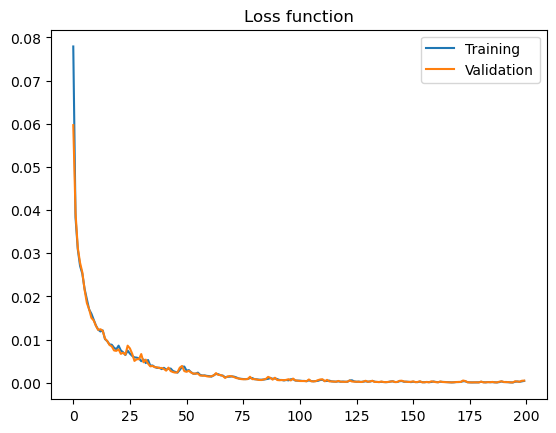

In [53]:
plt.plot(avg_train_loss, label='Training')
plt.plot(avg_val_loss, label='Validation')
plt.title('Loss function')
plt.legend()
plt.show()

3/3 [==============================] - 0s 4ms/step
Train Root Mean Squared Error: 0.02668953166893043
Train Mean Absolute Error: 0.022912273664478674
Train R2: 0.9839816405070697


Test Root Mean Squared Error: 0.027575481320158735
Test Mean Absolute Error: 0.130774083810736
Test R2: 0.3489255960776386




C:\Users\afs\AppData\Local\Temp\ipykernel_14912\3402225866.py:44: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].plot(pred_pairs_train.values(), 'o', color="red", label='true data', marker=".", markersize=5)
C:\Users\afs\AppData\Local\Temp\ipykernel_14912\3402225866.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[1].plot(pred_pairs_test.values(), 'o', color="red", label='true data', marker=".", markersize=5)


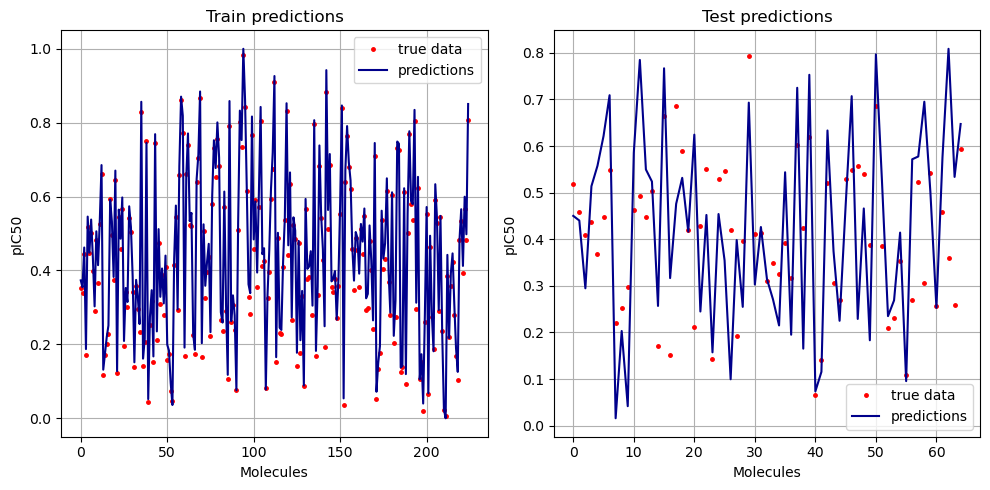

In [54]:
pred_Y_train_dnn = model_CNN.predict(train_X)
pred_Y_val_dnn = model_CNN.predict(val_X)
evaluate(train_Y, pred_Y_train_dnn, val_Y, pred_Y_val_dnn)
visualizeTrainTest(train_Y, pred_Y_train_dnn, val_Y, pred_Y_val_dnn)

In [55]:
for i in range(len(pred_Y_val_dnn)):
    print(pred_Y_val_dnn[i], val_Y[i])

[0.5184762] 0.45019920318725115
[0.4593509] 0.44023904382470136
[0.40917543] 0.2948207171314742
[0.43690148] 0.5139442231075698
[0.36789528] 0.5577689243027891
[0.39644477] 0.6215139442231076
[0.5486201] 0.709163346613546
[0.220011] 0.015936254980079667
[0.25197333] 0.2031872509960161
[0.2968087] 0.04183266932270935
[0.46376294] 0.5856573705179283
[0.49244884] 0.7848605577689246
[0.44748756] 0.5498007968127493
[0.50354356] 0.5239043824701198
[0.17125504] 0.25697211155378497
[0.6646705] 0.7669322709163348
[0.40130952] 0.31673306772908394
[0.58009195] 0.4760956175298806
[0.58962786] 0.5318725099601597
[0.41978112] 0.41633466135458186
[0.21238987] 0.6245019920318727
[0.42934704] 0.24501992031872522
[0.5507325] 0.4521912350597611
[0.14412509] 0.15737051792828682
[0.20870551] 0.45418326693227107
[0.54709834] 0.3545816733067729
[0.42085788] 0.09960159362549803
[0.19302167] 0.398406374501992
[0.4473893] 0.6215139442231076
[0.39654532] 0.254980079681275
[0.79270023] 0.6932270916334663
[0.41039

In [1]:
model_CNN.save('./models/cnn2.keras')

NameError: name 'model_CNN' is not defined